# Malaria parasite detection in thin-blood smear images

#### The goal of this project is to tackle a real world problem using convolutional neural networks. In this project, we will be dealing with real image files with different sizes, shapes etc.

ORIGINAL DATA SOURCE:
The dataset contains 2 folders - Infected - Uninfected and a total of 27,558 images.

Acknowledgements:
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

# Table of Contents

1. [Explore Data](#Explore-Data)
2. [Preparing the Data for the model](#Preparing-the-Data-for-the-model)
3. [Create a CNN Model](#Create-a-CNN-Model)
4. [Evaluate the Model](#Evaluate-the-Model)
5. [Test a single Image](#Test-a-single-Image)

Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
# Technically not necessary in newest versions of jupyter
%matplotlib inline

# Explore-Data

In [2]:
my_data_dir = 'cell_images'

In [3]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir) 

['train', 'test']

In [4]:
test_path =  os.path.join(my_data_dir, 'test')
train_path = os.path.join(my_data_dir, 'train')

In [5]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [6]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [7]:
# Set paths

train_parasitized_path= os.path.join(train_path, 'parasitized')
train_uninfected_path= os.path.join(train_path, 'uninfected')

test_parasitized_path= os.path.join(test_path, 'parasitized')
test_uninfected_path= os.path.join(test_path, 'uninfected')

In [8]:
# Check for files
print('Sample File in test path:  ', os.listdir(test_parasitized_path)[0])
print('Sample File in train path: ', os.listdir(train_parasitized_path)[0])

Sample File in test path:   C101P62ThinF_IMG_20150918_151507_cell_73.png
Sample File in train path:  C182P143NThinF_IMG_20151201_172216_cell_143.png


In [9]:
# pick a cell
random_pick_para= os.listdir(train_parasitized_path)[50]
para_cell = os.path.join(train_parasitized_path, random_pick_para)
# read the image as numpy array
para_img= imread(para_cell)

In [10]:
# Check shape
para_img.shape

(121, 103, 3)

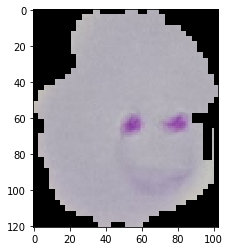

In [11]:
plt.imshow(para_img)

In [12]:
# pick a cell
random_pick_uni= os.listdir(train_uninfected_path)[60]
unifected_cell = os.path.join(train_uninfected_path, random_pick_uni)
# read the image as numpy array
unifected_img = imread(unifected_cell)

In [13]:
unifected_img.shape

(148, 160, 3)

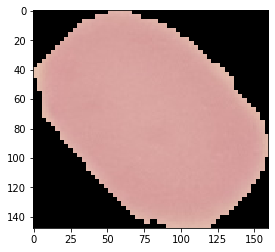

In [14]:
plt.imshow(unifected_img)

**Let's check how many images there are in train set.**

In [15]:
print('Number of images labeled as <Parasitized>: ' ,len(os.listdir(train_parasitized_path)))
print('Number of images labeled as <Uninfected>:  ' ,len(os.listdir(train_uninfected_path)))

Number of images labeled as <Parasitized>:  12480
Number of images labeled as <Uninfected>:   12479


**Let's find out the average dimensions of these images.**

In [16]:
unifected_img.shape

(148, 160, 3)

In [17]:
para_img.shape

(121, 103, 3)

In [18]:
para_img.max()

0.7921569

In [19]:
# Other options: https://stackoverflow.com/questions/1507084/how-to-check-dimensions-of-all-images-in-a-directory-using-python
dim1 = []
dim2 = []
for image_filename in os.listdir(train_uninfected_path):
    
    image_path= os.path.join(train_uninfected_path, image_filename)
    img = imread(image_path)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

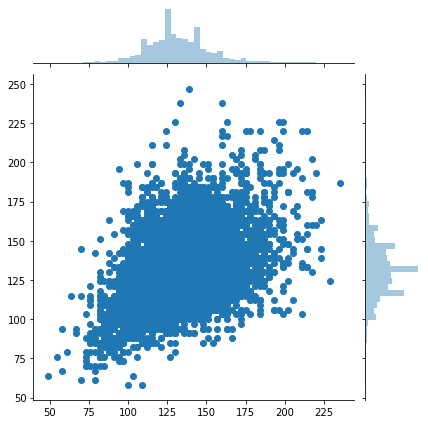

In [20]:
sns.jointplot(dim1,dim2)

In [21]:
np.median(dim1)

130.0

In [22]:
np.median(dim2)

130.0

In [23]:
# We set the input image shape to the average dimension
image_shape = (130,130,3)

# Preparing the Data for the model

There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

### Image Manipulation (Data Augmentation)

Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the **ImageDataGenerator** to do this automatically for us.

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [25]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               # rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest') # Fill in missing pixels with the nearest filled value

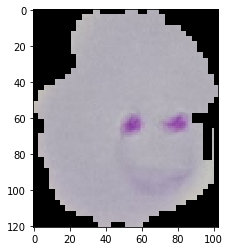

In [26]:
plt.imshow(para_img)

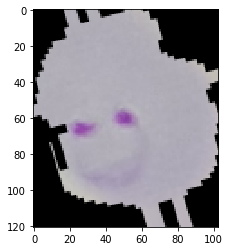

In [27]:
plt.imshow(image_gen.random_transform(para_img))

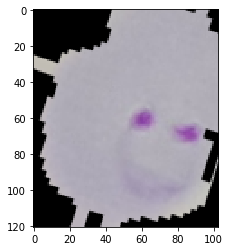

In [28]:
plt.imshow(image_gen.random_transform(para_img))

### Generating many manipulated images from a directory

In order to use .flow_from_directory, we must organize the images in sub-directories. The directories should only contain images of one class, so one folder per class of images.

Structure Needed:

* Image Data Folder
    * Class 1
        * 0.jpg
        * 1.jpg
        * ...
    * Class 2
        * 0.jpg
        * 1.jpg
        * ...
    * ...
    * Class n

In [29]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [30]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


# Create a CNN Model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [32]:
#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(32, (3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
# model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, it's binary so we use sigmoid
model.add(Dense(1, activation='sigmoid'))
# model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

## Early Stopping

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

In [35]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## Training the Model

In [36]:
batch_size = 16

In [37]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [38]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [39]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
# results = model.fit_generator(train_image_gen,epochs=20,
#                               validation_data=test_image_gen,
#                              callbacks=[early_stop])

In [38]:
# model.save('malaria_detector.h5')

In [41]:
from tensorflow.keras.models import load_model
model= load_model('malaria_detector.h5')

# Evaluate the Model

In [42]:
model.metrics_names

['loss', 'accuracy']

In [43]:
model.evaluate_generator(test_image_gen)

[1.9340006051807526, 0.8726923]

In [45]:
# losses = pd.DataFrame(model.history.history)
# losses[['loss','val_loss']].plot()

In [46]:
from tensorflow.keras.preprocessing import image

In [47]:
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
pred_probabilities = model.predict_generator(test_image_gen)

In [48]:
pred_probabilities

array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [1.],
       [0.]], dtype=float32)

In [49]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [78]:
predictions = pred_probabilities > 0.5

In [79]:
# Numpy can treat this as True/False for us
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [False]])

In [80]:
from sklearn.metrics import classification_report,confusion_matrix

In [81]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      1300
           1       0.97      0.76      0.85      1300

    accuracy                           0.87      2600
   macro avg       0.89      0.87      0.87      2600
weighted avg       0.89      0.87      0.87      2600



In [82]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1274,   26],
       [ 311,  989]])

# Test a single Image

In [83]:
para_cell

'cell_images/train/parasitized/C180P141NThinF_IMG_20151201_170110_cell_28.png'

In [84]:
my_image = image.load_img(para_cell,target_size=image_shape)

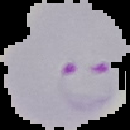

In [86]:
my_image

In [87]:
type(my_image)

PIL.Image.Image

In [88]:
my_image = image.img_to_array(my_image)

In [89]:
type(my_image)

numpy.ndarray

In [90]:
my_image.shape

(130, 130, 3)

In [91]:
my_image = np.expand_dims(my_image, axis=0)

In [92]:
my_image.shape

(1, 130, 130, 3)

In [93]:
model.predict(my_image)

array([[0.]], dtype=float32)

In [94]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [95]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}